In [114]:
import pylab as plt
import numpy as np
import skimage.transform
import skimage.restoration
from tqdm import tqdm
import skimage.filters
import torch
import torch.nn as nn
import typing as tp
from pyrofit.utils import pad_dims
from torch.nn.functional import grid_sample
from pyro import distributions as dist
from pyrofit.lensing.utils import get_meshgrid
from pyrofit.lensing.lenses import SPLELens
from pyrofit.lensing.sources import SersicSource, AnalyticSource
from pyrofit.utils.torchutils import _mid_many, unravel_index
from pyrofit.utils import kNN
from fft_conv_pytorch import fft_conv, FFTConv2d
import swyft

In [65]:
torch.cuda.set_device(0)
torch.set_default_tensor_type(torch.cuda.FloatTensor)
DEVICE='cuda'

In [66]:
NPIX = 5
CHANNELS = [0.5, 1, 2, 4, 8, 16, 32]
SIGMA = 0.2

## Helper classes and functions    

In [67]:
class RandomSource:
    def __init__(self, npix =  NPIX, channels = CHANNELS, K = 129):
        self._K = K
        self._channels = channels
        self._npix = npix
        
        self._kernels = self._get_kernels(self._K, self._channels)
        self._conv = self._get_kernel_conv(self._kernels)
        
    @staticmethod
    def _get_kernels(K, channels):
        C = len(channels)
        kernel = np.zeros((C, C, K, K))
        x = np.linspace(-64, 64, K)
        X, Y = np.meshgrid(x, x)
        R = (X**2 + Y**2)**0.5

        for i, s in enumerate(channels):
            kern = np.exp(-0.5*R**2/s**2)
            kern /= (kern**2).sum()**0.5
            kernel[i, i] = kern

        return kernel

    @staticmethod
    def _get_kernel_conv(kernel):
        C = len(kernel)
        K = len(kernel[0][0])
        gaussian_weights = nn.Parameter(torch.tensor(kernel).float().cuda())
        conv = FFTConv2d(in_channels = C, out_channels = C, kernel_size=K, bias=False, padding = int(K/2))
        with torch.no_grad():
            conv.weight = gaussian_weights
        return conv

    def _get_source_image(self, seeds, A=0.5, B = 0.9, C = 10.3, D = 4.):
        scales = A*(np.array(self._channels)/max(self._channels))**B
        seeds = seeds * torch.tensor(scales).cuda().float().unsqueeze(1).unsqueeze(2)
        x = torch.linspace(-1, 1, self._npix).to(seeds.device)
        X, Y = torch.meshgrid([x, x])
        R = (X**2 + Y**2)**0.5
        imgc = self._conv(seeds.unsqueeze(0)).squeeze(0).squeeze(0)
        img = imgc.sum(axis=-3)
        img = torch.exp(img)*(1/(1+(R/C)**D))
        return img

    def __call__(self):
        C = len(self._channels)
        return self._get_source_image(torch.randn(C, self._npix, self._npix).cuda()).detach()

In [68]:
class ArraySource(AnalyticSource):
    def __init__(self, image_array, x: float = 0., y: float = 0., scale: float = 1., peak_intensity: float = 1.,
                 origin: tp.Literal['lower', 'upper'] = 'lower', aspect=None, device=None):
        super().__init__(device=device)

        self.x, self.y = x, y
        self.peak_intensity = peak_intensity

        self.image = self._image(image_array, peak_intensity, device)

        if aspect is None:
            aspect = self.image.shape[-2] / self.image.shape[-1]
        self.semi_scale = torch.tensor([scale, (-1 if origin == 'lower' else 1) * aspect * scale], device=device) / 2

    def _image(self, image_array, peak_intensity=None, device=None) -> torch.Tensor:
        image = torch.tensor(image_array)
        if image.shape[-1] in (1, 3, 4):
            image = torch.movedim(image, -1, -3)
        if peak_intensity is not None:
            image = image.to(torch.get_default_dtype())
            image = image / torch.amax(image, (-2, -1), keepdim=True) * peak_intensity
        self.rollback_dims = image.ndim
        return pad_dims(image, ndim=4)[0].to(device=device, dtype=torch.get_default_dtype())

    def flux(self, X, Y):
        grid = torch.stack((X - self.x, Y - self.y), dim=-1).reshape(-1, *X.shape[-2:], 2) / self.semi_scale

        return grid_sample(
            self.image.expand(grid.shape[0], *self.image.shape[-3:]),
            grid,
            align_corners=True
        ).reshape(*X.shape[:-2], *self.image.shape[-self.rollback_dims:-2], *X.shape[-2:])


In [69]:
def deproject(image, X, Y, Xsrc, Ysrc):
        """Return indices into `Xsrc` and `Ysrc` closest to each point in `psrc`."""
        P = torch.stack((X, Y), -1).flatten(-3, -2)
        Psrc = torch.stack((Xsrc, Ysrc), -1).flatten(-3, -2)
        N = 2
        idx = unravel_index(kNN(P, Psrc, N).squeeze(-1), Xsrc.shape[-2:])
        idx = torch.reshape(idx, (NPIX, NPIX, N, 2))
        src_image = [image[idx[..., i,0], idx[..., i,1]] for i in range(N)]
        src_image = sum(src_image)/N
        return src_image

In [70]:
def image_generator(x, y, phi, q, r_ein, slope, src_image):
    res = 0.0125*8                      # resolution in arcsec
    nx, ny = 50, 50                   # number of pixels
    X, Y = get_meshgrid(res, nx, ny)    # grid

    # Lens
    lens = SPLELens(device=DEVICE)
    lens.XY = X,Y
    # Displacement field
    alphas = lens(x=x, y=y, phi=phi, q=q, r_ein=r_ein, slope=slope)

    # Lensing equation
    X_src = X - alphas[..., 0, :, :]
    Y_src = Y - alphas[..., 1, :, :]

    # Source
    source = ArraySource(src_image, peak_intensity = None, scale = 5)

    # Lensed source
    image = source(X=X_src, Y=Y_src)
    
    return image, [X, Y, X_src, Y_src]

## Test outputs

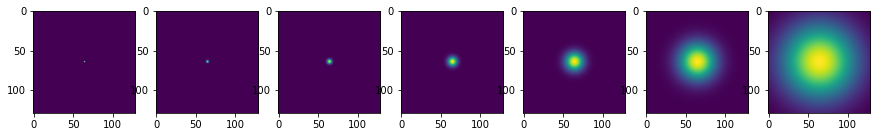

In [71]:
r = RandomSource(npix = NPIX)
kernel = r._kernels
plt.figure(figsize=(15, 5))
C = len(CHANNELS)
for i in range(C):
    plt.subplot(1, C, i+1)
    plt.imshow(kernel[i, i])

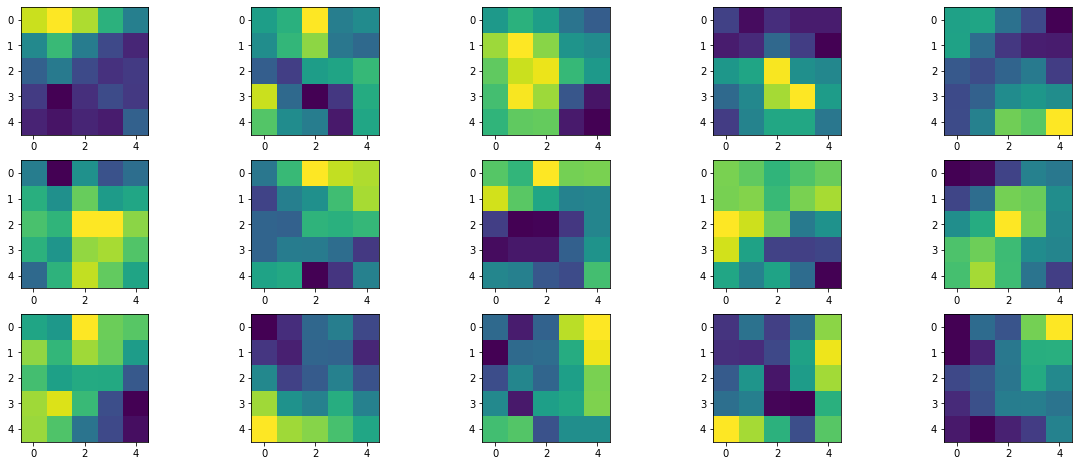

In [72]:
plt.figure(figsize=(20, 8))
for i in range(15):
    plt.subplot(3, 5, i+1)
    imgr = r()
    plt.imshow(imgr.detach().cpu())
    #plt.colorbar()

<ipython-input-68-6c7c12c26adf>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image_array)


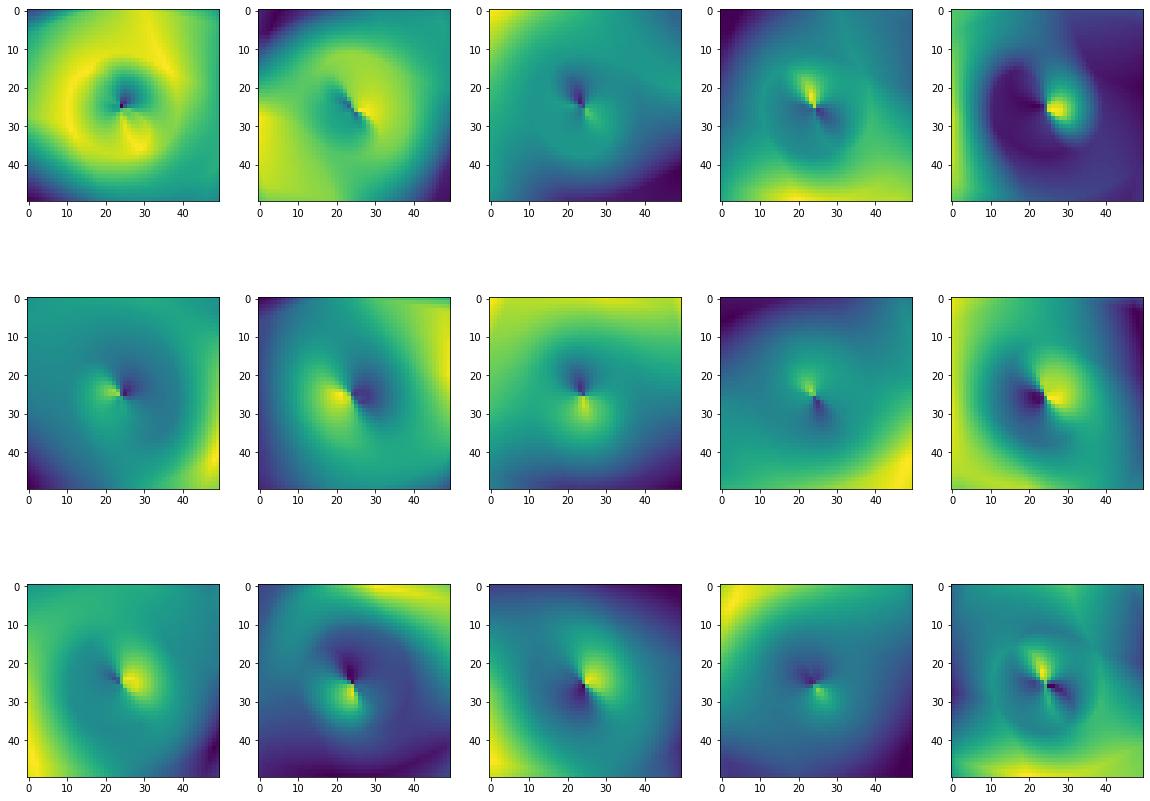

In [73]:
# Lens param
x = -0.05
y = 0.1
phi = 1.
q = 0.5
r_ein = 1.4
slope = 2.1

plt.figure(figsize=(20, 15))
for i in range(15):
    plt.subplot(3, 5, i+1)
    src_image = r()
    image, _ = image_generator(x, y, phi, q, r_ein, slope, src_image)
    plt.imshow(image.cpu())

## Model & prior

In [74]:
def model(v):
    x, y, phi, q, r_ein, slope = v[:6]
    src_image = r()
    img, coords = image_generator(x, y, phi, q, r_ein, slope, src_image)
    X, Y, Xsrc, Ysrc = coords
    return dict(img = img.cpu(), src = src_image.cpu(), X=X.cpu(), Y=Y.cpu(), Xsrc=Xsrc.cpu(), Ysrc=Ysrc.cpu())

In [75]:
def noise(sim, v, sigma = SIGMA):
    sim['img'] = sim['img'] + np.random.randn(50, 50)*sigma
    return sim

In [76]:
low =  np.array([-0.2, -0.2, 0, 0.2, 1.0, 1.5])
high = np.array([0.2, 0.2, 1.5, 0.9, 2.0, 2.5])
prior = swyft.get_uniform_prior(low, high)

## Training data generation

In [77]:
sim = swyft.Simulator(model, 6, dict(img=(50,50), src=(NPIX,NPIX), X=(50, 50), Y=(50,50), Xsrc=(50,50), Ysrc=(50,50)))

In [78]:
Ntrain = 500

store = swyft.Store.memory_store(sim)
store.add(Ntrain, prior)
store.simulate()

Creating new store.
Store: Adding 487 new samples to simulator store.


<ipython-input-68-6c7c12c26adf>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image_array)


## SWYFT analysis

### Training dataset

In [79]:
torch.set_default_tensor_type(torch.FloatTensor)  # Needing this is kinda stupid

In [80]:
dataset = swyft.Dataset(Ntrain, prior, store, simhook = noise)

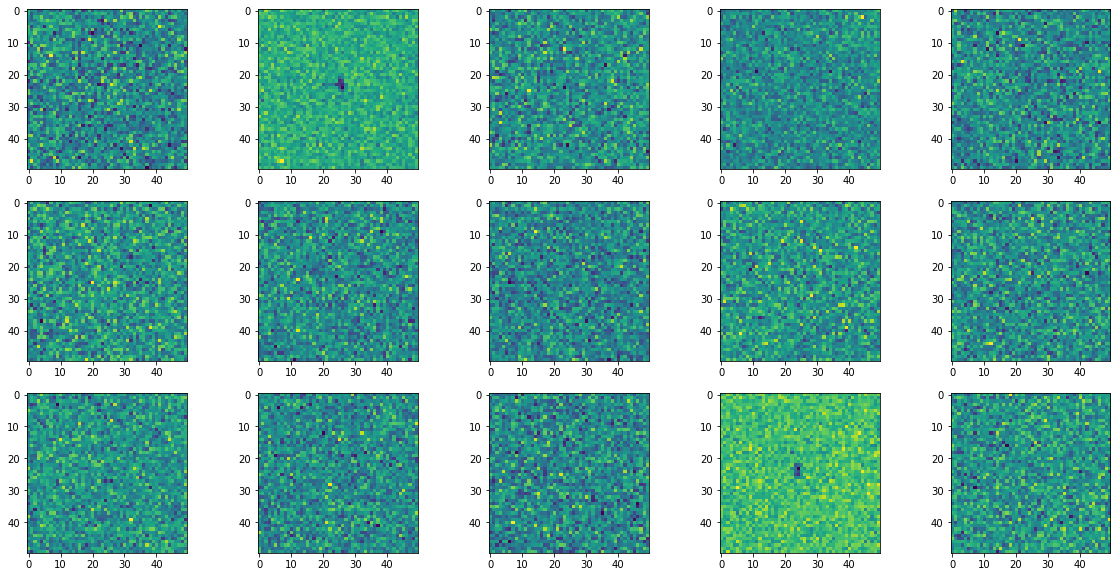

In [81]:
plt.figure(figsize=(20, 10))
for i in range(15):
    plt.subplot(3, 5, i+1)
    plt.imshow(dataset[i][0]['img'])

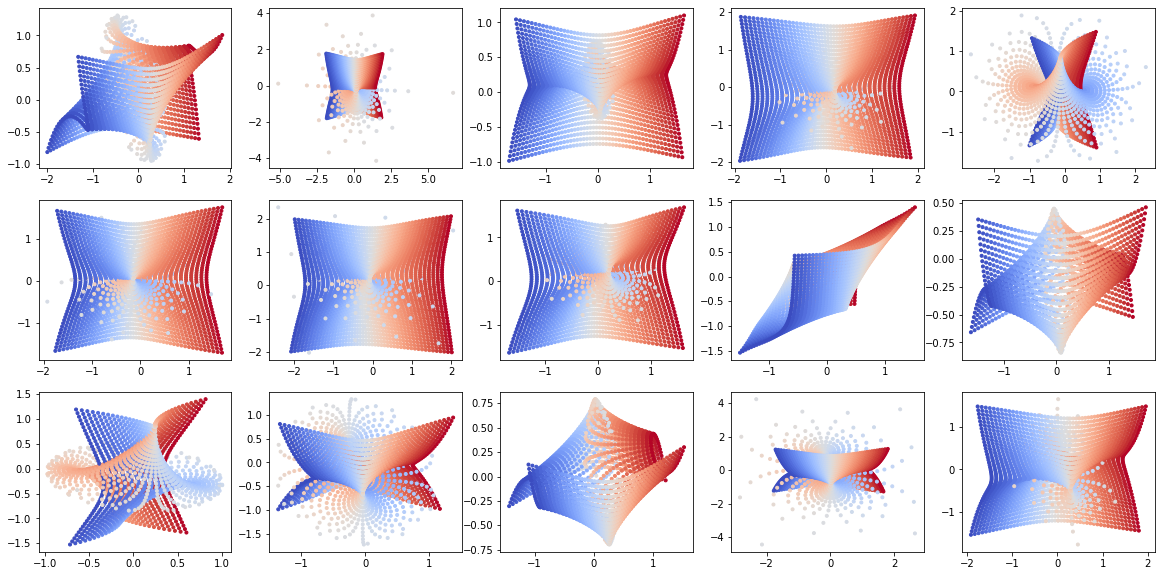

In [82]:
plt.figure(figsize=(20, 10))
for i in range(15):
    plt.subplot(3, 5, i+1)
    plt.scatter(dataset[i][0]['Xsrc'], dataset[i][0]['Ysrc'], marker='.', c=dataset[i][0]['X'], cmap='coolwarm')

### Dataset Src to params

In [83]:
# Since we want to learn the src parameters, which are generated inside the generative model, 
# we simply attach the flattened src array to the parameter vectors and hope for the best

class DatasetAddSrcToParms(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self._dataset = dataset

    def __len__(self):
        return len(self._dataset)
    
    def __getitem__(self, i):
        src  = self._dataset[i][0]['src'].cpu().flatten()
        #src  += torch.randn_like(src)*0.001
        u  = self._dataset[i][1]
        v  = self._dataset[i][2]
        u = torch.cat([u, src])
        v = torch.cat([v, src])
        return (self._dataset[i][0], u, v)

dataset_src_as_param = DatasetAddSrcToParms(dataset)

### Custom networks (taken from Elias)

In [104]:
class CustomObservationTransform(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.n_features = None

    def forward(self, obs: dict) -> torch.Tensor:      
        src = obs['src']  # Needs to be replaced with estimating the src from images
        return src
        #img = obs['img']
        #X = obs['X']
        #Y = obs['Y']
        #Xsrc = obs['Xsrc']
        #Ysrc = obs['Ysrc']
        #print(X.shape)
        #print(Y.shape)
        #print(Xsrc.shape)
        #print(Ysrc.shape)
        #src = deproject(img, X, Y, Xsrc, Ysrc)
        #print(src.shape)
        #self.UNet = UNET(in_channels = 1, out_channels = self.out_channels)        
        #print("Image shape:", x.shape)
        
class CustomMarginalClassifier(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.n_features = None
        
        N = NPIX*NPIX
        
        self.logInvVar = nn.Parameter(torch.zeros(N)+4.6)  # std = 0.1
        self.logNorm = nn.Parameter(torch.zeros(N))
        
        #self.a = nn.Parameter(torch.randn(N))
        #self.b = nn.Parameter(torch.randn(N))
        #print(self.a.view(-1,400,400)[:,195:205, 195:205].mean())
        #print(self.logSigma)

        self.Lx = swyft.networks.LinearWithChannel(N, 1, 1)
        self.Lz = swyft.networks.LinearWithChannel(N, 1, 1)
        #self.L = swyft.networks.LinearWithChannel(N, 2, 1)
        self.bn_x = torch.nn.LazyBatchNorm1d(affine = False, momentum = 0.1, eps = 1e-10)
        self.bn_z = torch.nn.LazyBatchNorm1d(affine = False, momentum = 0.1, eps = 1e-10)
        self.beta = None
                
    def forward2(self, x: torch.Tensor, z: torch.Tensor) -> torch.Tensor:
        x = x.view(-1, 400*400)
        a, b, = self.a, self.b
        logInvVar = self.logInvVar
        logInvVar = torch.zeros_like(logInvVar) -5 
        invVar = torch.exp(logInvVar)  # reconstruction uncertainty
        #x1 = self.Lx(x.unsqueeze(-1)).squeeze(-1)  # predicted flux
        #z1 = self.Lz(z.unsqueeze(-1)).squeeze(-1)  # predicted flux
        z1 = z
        x1 = a+b*x
        print(a.view(-1,400,400)[:,195:205, 195:205].mean().item(),
              b.view(-1,400,400)[:,195:205, 195:205].mean().item(),
              logInvVar.view(-1,400,400)[:,195:205, 195:205].mean().item(),
              self.logNorm.view(-1,400,400)[:,195:205, 195:205].mean().item()
             )
        #x1 = x
        #z1 = z
        r = -0.5*(x1 - z1)**2*invVar + self.logNorm + 0.5*logInvVar
        r = r.view(-1, 400, 400)
        r = r[..., 195:205, 195:205]*1.
        r = r.view(-1, 10*10)
        return r
    
    def forward(self, x: torch.Tensor, z: torch.Tensor) -> torch.Tensor:
        #plt.subplot(1, 2, 1)
        #plt.imshow(x[0].detach().cpu())
        #plt.colorbar()
        #plt.subplot(1, 2, 2)
        #plt.imshow(z.view(-1, NPIX, NPIX)[0].detach().cpu())
        #plt.colorbar()
        
        x = x.view(-1, NPIX*NPIX)
        
        z += torch.randn_like(z)*1e-3
        z = self.Lz(z.unsqueeze(-1)).squeeze(-1)
        #print(z.std())
        xb = self.bn_x(x)
        zb = self.bn_z(z)
        
        momentum = 0.1
        if self.training:
            batch_size = len(xb)
            idx = np.array([[i, i+3] for i in np.arange(0, batch_size, 4)]).flatten()
            beta_batch = (xb*zb)[idx].mean(dim=0)
            if self.beta is None:
                self.beta = beta_batch.detach()
            else:
                self.beta = (1-momentum)*self.beta + momentum * beta_batch.detach()
            
            th = 0.99
            self.beta[self.beta >  th] = th
            self.beta[self.beta < -th] = -th    
        
        r = -self.beta**2/2/(1-self.beta**2)*(xb**2+zb**2-2*self.beta*xb*zb) - 0.5*torch.log(1-self.beta**2)
        print(r[0:4, 0:2])
        return r
            
        #print(z.std(dim=(0)))
        #print(zb.std(dim=(0)))
        #print(x.shape)
        #print(z.shape)
        #y = torch.cat([x.unsqueeze(-1), z.unsqueeze(-1)], dim = -1)
        #y = self.L(y).squeeze(-1).detach()
        #a, b, = self.a, self.b
        logInvVar = self.logInvVar
        logInvVar = torch.zeros_like(logInvVar) + 4.6 + 2
        invVar = torch.exp(logInvVar)  # reconstruction uncertainty
        #x1 = self.Lx(x.unsqueeze(-1)).squeeze(-1)  # predicted flux
        #z1 = self.Lz(z.unsqueeze(-1)).squeeze(-1)  # predicted flux
        x = self.Lx(x.unsqueeze(-1)).squeeze(-1)
        #z1 = z
        #x1 = a+b*x
        #print(#a.view(-1,400,400)[:,195:205, 195:205].mean().item(),
              #b.view(-1,400,400)[:,195:205, 195:205].mean().item(),
        #      logInvVar.view(-1,400,400)[:,195:205, 195:205].mean().item(),
        #      self.logNorm.view(-1,400,400)[:,195:205, 195:205].mean().item()
        #     )
        r = -0.5*(z-x)**2*invVar + 0.5*logInvVar # - 10 #+ self.logNorm + 
        #r = self.bn(r)
        #y = (x-z)[0]
        print(
                #r.min().item(),
                #r.max().item(),
                #self.logNorm.mean().item(),
                #self.logInvVar.mean().item(),
             )
        return r

class CustomParameterTransform(torch.nn.Module):
    def __init__(self) -> None:
        super().__init__()
        
    def forward(self, v):
        v = v[..., 6:]
        return v

In [105]:
observation_transform = CustomObservationTransform()
parameter_transform = CustomParameterTransform()
marginal_classifier = CustomMarginalClassifier()

In [106]:
network_1d = swyft.networks.Network(observation_transform, parameter_transform, marginal_classifier)

mre_1d = swyft.MarginalRatioEstimator(
    marginal_indices=[(1,)],
    network=network_1d,
    device=DEVICE,
)

### Training

In [107]:
opt =  torch.optim.Adam

In [108]:
vl = mre_1d.train(dataset_src_as_param, batch_size = 128, max_epochs = 5, learning_rate = 1e0, optimizer = opt)

tensor([[1.9571, 1.9511],
        [1.9107, 1.8492],
        [1.8787, 1.8265],
        [1.9575, 1.9548]], device='cuda:0', grad_fn=<SliceBackward>)
tensor([[ -1.9843,   1.7660],
        [ -0.2444, -97.1345],
        [ -0.2437, -98.4767],
        [ -6.0750,   1.0114]], device='cuda:0', grad_fn=<SliceBackward>)
tensor([[-5.2206e-01,  1.0750e+00],
        [ 8.7687e-02, -9.7546e+01],
        [ 8.8759e-02, -9.6891e+01],
        [-1.0201e-01,  1.7346e+00]], device='cuda:0', grad_fn=<SliceBackward>)
tensor([[  -1.9467, -326.4475],
        [  -1.9078, -357.2053],
        [  -1.9209, -317.7975],
        [  -1.8788, -347.0691]], device='cuda:0')
training: lr=1, epoch=1, validation loss=3234tensor([[0.1135, 1.9513],
        [0.1135, 1.8370],
        [0.1135, 1.9139],
        [0.1135, 1.9528]], device='cuda:0', grad_fn=<SliceBackward>)
tensor([[-5.9888e-02,  1.7656e+00],
        [-6.0939e-02, -9.8429e+01],
        [-6.2783e-02, -9.6728e+01],
        [-2.4207e-01,  1.0080e+00]], device='cuda:0', gra

KeyboardInterrupt: 

In [ ]:
plt.imshow(network_1d.marginal_classifier.logSigma.view(400, 400).detach().cpu())
plt.colorbar()

### Results

In [ ]:
posterior_1d = swyft.MarginalPosterior(mre_1d, prior)

In [ ]:
obs0, _, v0 = dataset[1]
samples_1d = posterior_1d.weighted_sample(10000, obs0)
plt.imshow(obs0['img'])
plt.colorbar()

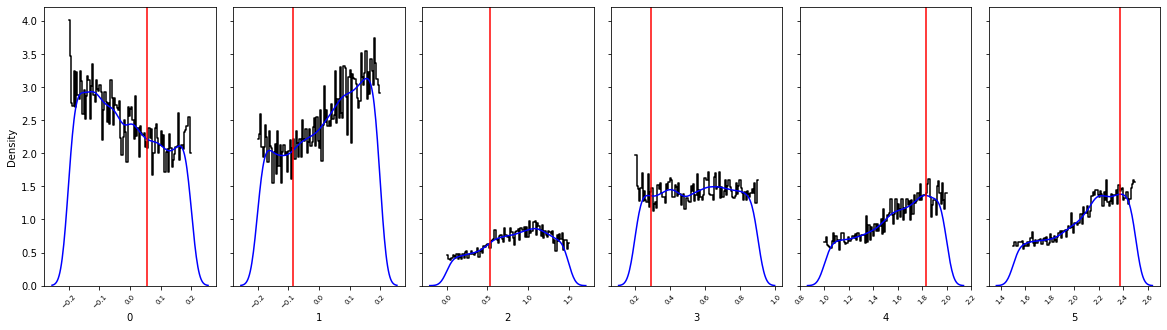

In [56]:
swyft.hist1d(samples_1d, kde = True, figsize = (20, 5), truth = v0);